# Coasties Ship Detection using NOAA National Geodetic Survey Tampa Image Data Set
## JAIC Create AI Jan 2022 Cohort 
#### Students
* Sydney Wagner
* Amilynn Adams
* Evan Twarog
* David Couture

#### Facilitator
* Bruce Goldfeder

## Presentation Date April 22, 2022
* Ship Object Detection using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon
* Forked from Henri Mendoca Kaggle Notebook - https://www.kaggle.com/code/hmendonca/airbus-mask-rcnn-and-coco-transfer-learning

## Generic port to Google Colab
This version of the code is a move from Kaggle to Google Colab and a switch to just using the Training data provided for Training, Validation, as well as Testing.  An independent assessment will need to be coded to account for the lack of Kaggle training set.




In [1]:
#delete me after code is ported externally

#!pip freeze > requirements.txt
#!cat requirements.txt
# This code downloads the Kaggle local file to your system
#from IPython.display import FileLink
#FileLink(r'requirements.txt')

In [2]:
#delete me after code is ported externally

#!pwd
#!ls -al

In [3]:
# Commiting for submission
#debug = False
debug = True

# Step One - Setup
1. Import required libraries
2. Declare constants for data and output folders
3. Import Matterport Mask-RCNN
4. Download Pretrained COCO weights
5. Create Configuration for model parameters
6. Create Utility functions for manipulating image and mask data


* ### 1.1 Import python libraries

In [4]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
from skimage.io import imread
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight
from tabulate import tabulate

import tensorflow as tf
tf.test.is_gpu_available()

True

In [5]:
#!pip install opencv-python
#!pip install matplotlib
#!pip install scikit-image
#!pip install imgaug
#!pip install tqdm
#!pip install pandas
#!pip install tabulate

* ### 1.2 Declare constants for folder locations

In [6]:
# Location for kaggle data for airbus ship detection
#DATA_DIR = '/kaggle/input/airbus-ship-detection'
DATA_DIR = '/home/bruce/dev/kaggle/airbus-ship-detections/input/'

# Directory to save logs and trained model
#ROOT_DIR = '/kaggle/working'
ROOT_DIR = '/home/bruce/dev/kaggle/airbus-ship-detections/nbs/'

# Location for train and test data
train_dir = os.path.join(DATA_DIR, 'train_v2')
test_dir = os.path.join(DATA_DIR, 'test_v2')

* ### 1.3 Install Matterport's Mask-RCNN model from github.
    * See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [7]:
# Download the Mask-RCNN from Github
#!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


* ### 1.4 Download COCO pre-trained weights

In [8]:
# Download the weights
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

# Set constant for path to weights
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-rw-r-- 1 bruce bruce 246M Dec  6 13:58 mask_rcnn_coco.h5


* ### 1.5 Configuration paramters for Mask-RCNN

    * Hardware based configurations 
    * Architecture based configurations
    * Mask-RCNN algorithm based configurations

In [9]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'airbus'
    
    # Hardware based config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 9
    
    # Architecture based config
    BACKBONE = 'resnet50'    
    NUM_CLASSES = 2  # background and ship classes
    
    # Algorithm based config
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (8, 16, 32, 64)
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 10
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.0
    
    STEPS_PER_EPOCH = 15 if debug else 150
    VALIDATION_STEPS = 10 if debug else 125
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     9
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 9
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE             

**Train: 192556 (768,768,3)**  
**Test :  15606 (768,768,3)**

* ### 1.6 Utility functions for image and mask data manipulation
    * Making montages from several images 
    * Run Length Encoding (RLE) decoding and encoding to parse the RLE formatted masking data in the csv data files
    * Converting mask data into images for viewing

In [10]:
# Function for creating montages of several images
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1) # to rgb function

# RLE encode and decode functions
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]


def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None): # raster to rle coding 
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)): # rle coding to raster
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

# Mask image creation black and white and color for mulitple ships for viewing
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

# Step Two - Data Exploration and Cleaning
* ### Read in and view the image mask data in RLE format
    * RLE is run-length encoding. It is used to encode the location of foreground objects in segmentation. Instead of outputting a mask image, you give a list of start pixels and how many pixels after each of those starts is included in the mask.

In [11]:
# Read in the mask data from the training dataset
SEGMENTATION = DATA_DIR + '/train_ship_segmentations_v2.csv'
anns = pd.read_csv(SEGMENTATION)

# Display the first five rows first is truncated second is full RLE listing for mask
print(anns[:5])
print('\nSame table with full listing for RLE encoded pixels\n')
print(tabulate(anns[:5],headers='firstrow'))


         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

Same table with full listing for RLE encoded pixels

  0  00003e153.jpg    nan
---  ---------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

* ### Remove all the junk images
    * Cleaning the data by removing all invalid images from the train and test data sets
    * These were provided by forked version

In [12]:
# Note that this step may not be needed as the training only uses positive training of images with ships
# None of the images that are unreadable have any ships on them

from PIL import Image
from sklearn.model_selection import train_test_split

exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(train_dir) if f not in exclude_list]
test_names = [f for f in os.listdir(test_dir) if f not in exclude_list]

print(len(train_names), len(test_names))

192555 15606


In [13]:
#!pip install -U scikit-learn

* ### Create the Train and Validation data sets (called test)

In [14]:
# Note - this value is overwriting the assignment in above cell, why? None of them have ships in them so OK
train_names = anns[anns.EncodedPixels.notnull()].ImageId.unique().tolist()  ## override with ships
print('Are bad images in files with ships? ',exclude_list in train_names)
print("Uniq image list containing ships:",np.shape(train_names))

test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU # 10*9
print('Test Size is ', test_size)
image_fps_train, image_fps_val = train_test_split(train_names, test_size=test_size, random_state=42)

if debug:
    image_fps_train = image_fps_train[:100]
    image_fps_val = image_fps_val[:100]
    test_names = test_names[:100]
    
print("train:",len(image_fps_train), "val:",len(image_fps_val), "test:",len(test_names))

# TODO - not sure why this is here
image_fps, image_annotations = train_names, anns
print("Uniq image list containing ships:",np.shape(image_fps))
print("Train ship segmentations csv file:",np.shape(image_annotations))

Are bad images in files with ships?  False
Uniq image list containing ships: (42556,)
Test Size is  90
train: 100 val: 90 test: 100
Uniq image list containing ships: (42556,)
Train ship segmentations csv file: (231723, 2)


* ### Class for loading and viewing the image and mask data combined
    * Encapsulation in a class makes this set of data reads and functions easier to use

In [15]:
class DetectorDataset(utils.Dataset):
    """
    Dataset class for training our dataset.
    This class inherits from the MRCNN.utils.Dataset class and is used for preparing
    data to be input into a Matterport Mask-RCNN model for training and inference
    https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py 
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('ship', 1, 'Ship')
        
        # add images by iterating through the files names getting index and filename
        for i, fp in enumerate(image_fps):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(train_dir, fp), 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

* ### Take a look at an image with a ship on it

Image original size: 768


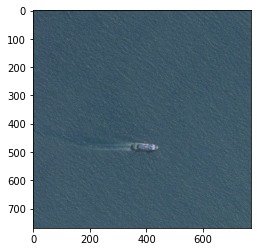

In [16]:
ds = imread(os.path.join(train_dir, image_fps[0])) # read  image from filepath 
plt.imshow(ds)

# Original image size: 768 x 768
ORIG_SIZE = ds.shape[0]
print("Image original size:",ORIG_SIZE)

* ### Format the training and validation datasets for Matterport Mask-RCNN

In [17]:
%%time
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

CPU times: user 583 ms, sys: 3.04 ms, total: 586 ms
Wall time: 585 ms


In [18]:
%%time
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

CPU times: user 524 ms, sys: 0 ns, total: 524 ms
Wall time: 522 ms


* ### Display a random image with bounding boxes

image shape: (768, 768, 3)
mask shape : (768, 768, 2)
image file: /home/bruce/dev/kaggle/airbus-ship-detections/input/train_v2/18216f23b.jpg class_id: [1 1]


/tmp/ipykernel_151068/751569827.py:48: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), class_ids.astype(np.int32)


(-0.5, 767.5, 767.5, -0.5)

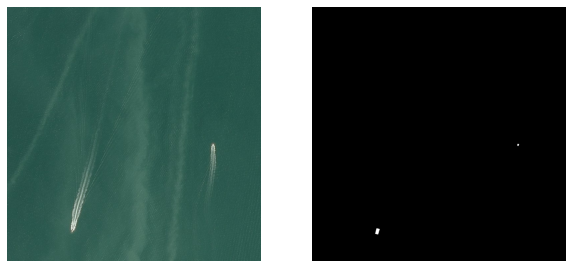

In [19]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids) # random image id 0-90
    image_fp = dataset_val.image_reference(image_id) # current image
    image = dataset_val.load_image(image_id) # load image
    mask, class_ids = dataset_val.load_mask(image_id)
print("image shape:",image.shape)
print("mask shape :",mask.shape)
print("image file:",image_fp, "class_id:",class_ids)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += mask[:, :, i] ## * image[:, :, 0]
plt.imshow(masked, cmap='gray')
plt.axis('off')

* ### Image Augmentation used to mutate images to increase number of input images for training

/home/bruce/.local/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


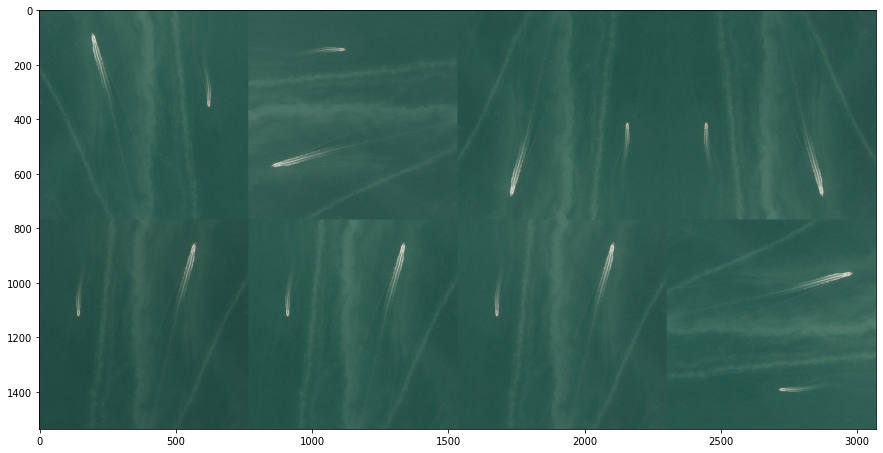

In [20]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## rotate
        iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
        iaa.Affine(rotate=180),
        iaa.Affine(rotate=270),
    ]),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image, cols=4, rows=2)
plt.figure(figsize=(15, 15))
plt.imshow(imggrid.astype(int))

## Step Three - Training the model
On a P100 GPU debug size takes about 10 minutes, non-debug about 90 minutes

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [21]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR) #  ROOT_DIR:output path

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [22]:
LEARNING_RATE = 0.003

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [23]:
%%time
## train heads with higher lr to speedup the learning  2*LEARNING_RATE
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: /home/bruce/dev/kaggle/airbus-ship-detections/nbs/airbus20220419T0959/mask_rcnn_airbus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Time

ResourceExhaustedError: OOM when allocating tensor with shape[576,256,7,7] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training/SGD/gradients/mrcnn_class_conv1/convolution_grad/Conv2DBackpropInput (defined at /home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'training/SGD/gradients/mrcnn_class_conv1/convolution_grad/Conv2DBackpropInput':
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/bruce/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/bruce/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/home/bruce/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/bruce/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/bruce/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
    await self.process_one()
  File "/home/bruce/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 493, in process_one
    await dispatch(*args)
  File "/home/bruce/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
    await result
  File "/home/bruce/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
    reply_content = await reply_content
  File "/home/bruce/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bruce/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
    result = self._run_cell(
  File "/home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
    return runner(coro)
  File "/home/bruce/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_151068/3807087532.py", line 1, in <cell line: 1>
    get_ipython().run_cell_magic('time', '', "## train heads with higher lr to speedup the learning  2*LEARNING_RATE\nmodel.train(dataset_train, dataset_val,\n            learning_rate=LEARNING_RATE*2,\n            epochs=2,\n            layers='heads',\n            augmentation=None)  ## no need to augment yet\n\nhistory = model.keras_model.history.history\n")
  File "/home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2347, in run_cell_magic
    result = fn(*args, **kwargs)
  File "/home/bruce/.local/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1316, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 2, in <module>
  File "/home/bruce/dev/kaggle/airbus-ship-detections/Mask_RCNN/mrcnn/model.py", line 2364, in train
    self.keras_model.fit_generator(
  File "/home/bruce/.local/lib/python3.8/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/bruce/.local/lib/python3.8/site-packages/keras/engine/training.py", line 2080, in fit_generator
    self._make_train_function()
  File "/home/bruce/.local/lib/python3.8/site-packages/keras/engine/training.py", line 988, in _make_train_function
    training_updates = self.optimizer.get_updates(
  File "/home/bruce/.local/lib/python3.8/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/bruce/.local/lib/python3.8/site-packages/keras/optimizers.py", line 173, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/bruce/.local/lib/python3.8/site-packages/keras/optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/bruce/.local/lib/python3.8/site-packages/keras/backend/tensorflow_backend.py", line 2515, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/ops/gradients_impl.py", line 155, in gradients
    return gradients_util._GradientsHelper(
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/ops/gradients_util.py", line 702, in _GradientsHelper
    in_grads = _MaybeCompile(grad_scope, op, func_call,
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/ops/gradients_util.py", line 362, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/ops/gradients_util.py", line 703, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/ops/nn_grad.py", line 587, in _Conv2DGrad
    gen_nn_ops.conv2d_backprop_input(
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/ops/gen_nn_ops.py", line 1400, in conv2d_backprop_input
    _, _, _op = _op_def_lib._apply_op_helper(
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/op_def_library.py", line 792, in _apply_op_helper
    op = g.create_op(op_type_name, inputs, dtypes=None, name=scope,
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/util/deprecation.py", line 513, in new_func
    return func(*args, **kwargs)
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py", line 3356, in create_op
    return self._create_op_internal(op_type, inputs, dtypes, input_types, name,
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py", line 3418, in _create_op_internal
    ret = Operation(
  File "/home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'mrcnn_class_conv1/convolution', defined at:
  File "usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "home/bruce/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "home/bruce/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "home/bruce/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "home/bruce/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "home/bruce/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
    await self.process_one()
  File "home/bruce/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 493, in process_one
    await dispatch(*args)
  File "home/bruce/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
    await result
  File "home/bruce/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
    reply_content = await reply_content
  File "home/bruce/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "home/bruce/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
    result = self._run_cell(
  File "home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
    return runner(coro)
  File "home/bruce/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "home/bruce/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "tmp/ipykernel_151068/2329206222.py", line 1, in <cell line: 1>
    model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR) #  ROOT_DIR:output path
  File "home/bruce/dev/kaggle/airbus-ship-detections/Mask_RCNN/mrcnn/model.py", line 1837, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "home/bruce/dev/kaggle/airbus-ship-detections/Mask_RCNN/mrcnn/model.py", line 1995, in build
    fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
  File "home/bruce/dev/kaggle/airbus-ship-detections/Mask_RCNN/mrcnn/model.py", line 927, in fpn_classifier_graph
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (pool_size, pool_size), padding="valid"),
  File "home/bruce/.local/lib/python3.8/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "home/bruce/.local/lib/python3.8/site-packages/keras/layers/wrappers.py", line 211, in call
    y = self.layer.call(inputs, **kwargs)
  File "home/bruce/.local/lib/python3.8/site-packages/keras/layers/convolutional.py", line 162, in call
    outputs = K.conv2d(
  File "home/bruce/.local/lib/python3.8/site-packages/keras/backend/tensorflow_backend.py", line 3329, in conv2d
    x = tf.nn.convolution(
  File "home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/ops/nn_ops.py", line 914, in convolution
    return convolution_internal(
  File "home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/ops/nn_ops.py", line 1025, in convolution_internal
    return op(
  File "home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/ops/gen_nn_ops.py", line 1067, in conv2d
    _, _, _op = _op_def_lib._apply_op_helper(
  File "home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/op_def_library.py", line 792, in _apply_op_helper
    op = g.create_op(op_type_name, inputs, dtypes=None, name=scope,
  File "home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/util/deprecation.py", line 513, in new_func
    return func(*args, **kwargs)
  File "home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py", line 3356, in create_op
    return self._create_op_internal(op_type, inputs, dtypes, input_types, name,
  File "home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py", line 3418, in _create_op_internal
    ret = Operation(
  File "home/bruce/.local/lib/python3.8/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [24]:
#!pip install scikit-image==0.15

In [25]:
#!pip install keras==2.1.5

In [26]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [27]:
%%time
 # LEARNING_RATE
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=4 if debug else 14,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.003

Checkpoint Path: /home/bruce/dev/kaggle/airbus-ship-detections/nbs/airbus20220419T0959/mask_rcnn_airbus_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b     

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[576,14,14,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node mrcnn_mask_conv3/BiasAdd-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss_1/add_5/_4333]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[576,14,14,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node mrcnn_mask_conv3/BiasAdd-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [28]:
%%time
### LEARNING_RATE/2 fine tuning 
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/2,
            epochs=6 if debug else 22,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.0015

Checkpoint Path: /home/bruce/dev/kaggle/airbus-ship-detections/nbs/airbus20220419T0959/mask_rcnn_airbus_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b    

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[576,14,14,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node mrcnn_mask_conv2/BiasAdd-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss_2/add_5/_5575]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[576,14,14,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node mrcnn_mask_conv2/BiasAdd-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [29]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

NameError: name 'history' is not defined

In [ ]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch:{best_epoch+1} val_loss:{score}')

In [ ]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))

fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

## Step Four - Run the Test set and submit

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

* ### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(8):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
#     print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

* ### Final steps - Create the filtered submission file

In [ ]:
# Get filenames of test dataset images
test_image_fps = test_names

In [ ]:
DETECTION_TEST_PRED = '/kaggle/input/fine-tuning-resnet34-on-ship-detection-new-data/ship_detection.csv'
ship_detection = pd.read_csv(DETECTION_TEST_PRED, index_col='id')
ship_detection.head()

In [ ]:
THRESHOLD = 0.45
test_names_nothing = ship_detection.loc[ship_detection['p_ship'] <= THRESHOLD].index.tolist()
len(test_names_nothing), len(ship_detection), len(test_names_nothing)/len(ship_detection)

In [ ]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=config.DETECTION_MIN_CONFIDENCE):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("ImageId,EncodedPixels\n")

        for image_id in tqdm(image_fps):
            found = False
            
            if image_id not in test_names_nothing:
                image = imread(os.path.join(test_dir, image_id))
                # If grayscale. Convert to RGB for consistency.
                if len(image.shape) != 3 or image.shape[2] != 3:
                    image = np.stack((image,) * 3, -1)
#                 image, window, scale, padding, crop = utils.resize_image(
#                     image,
#                     min_dim=config.IMAGE_MIN_DIM,
#                     min_scale=config.IMAGE_MIN_SCALE,
#                     max_dim=config.IMAGE_MAX_DIM,
#                     mode=config.IMAGE_RESIZE_MODE)

                results = model.detect([image])
                r = results[0]

                assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
                if len(r['rois']) == 0:
                    pass  ## no ship
                else:
                    num_instances = len(r['rois'])

                    for i in range(num_instances):
                        if r['scores'][i] > min_conf:
#                             print(r['scores'][i], r['rois'][i], r['masks'].shape, np.sum(r['masks'][...,i]))
#                             plt.imshow(r['masks'][...,i], cmap=get_cmap('jet'))
                            file.write(image_id + "," + rle_encode(r['masks'][...,i]) + "\n")
                            found = True

            if not found:
                file.write(image_id + ",\n")  ## no ship

In [ ]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

In [ ]:
sub = pd.read_csv(submission_fp)
print(sub.EncodedPixels.isnull().sum(), sub.ImageId.nunique(), sub.EncodedPixels.isnull().sum()/sub.ImageId.nunique())
sub.head(50)

In [ ]:
# show a few test image detection example
def visualize_test(): 
    image_id = random.choice(test_names)
    
    # original image
#     print(image_id)
    image = imread(os.path.join(test_dir, image_id))
    
    # assume square image 
    resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
#     image, window, scale, padding, crop = utils.resize_image(
#         image,
#         min_dim=config.IMAGE_MIN_DIM,
#         min_scale=config.IMAGE_MIN_SCALE,
#         max_dim=config.IMAGE_MAX_DIM,
#         mode=config.IMAGE_RESIZE_MODE)

    results = model.detect([image])
    r = results[0]
    for bbox in r['rois']: 
#         print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
#         print("x {} y {} h {} w {}".format(x1, y1, width, height))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title(f"{image_id}")
    ax1.imshow(image)
    ax2.set_title(f"{len(r['rois'])} masks if prob:{ship_detection.loc[image_id][0]:.6f}")
    ax2.imshow(masks_as_color(sub.query(f"ImageId=='{image_id}'")['EncodedPixels']))

for i in range(8):
    visualize_test()

In [ ]:
# Save a local copy of the submission file just in case
#!cd /kaggle/working
from IPython.display import FileLink
FileLink(r'./submission.csv')

In [ ]:
# remove files to allow committing (hit files limit otherwise)
!rm -rf /kaggle/working/Mask_RCNN